Lets load in the libraries we will be using

In [86]:
from sqlalchemy import create_engine
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt
import datetime


Read the csv files, create a new key column and fill it with the file name, concat, and get a description of the data. lets take a look at some of the statistical moments that occur within the data. 

In [93]:
path = r'C:\Users\levos\OneDrive\Python\Tagup\machine_data' # path
all_files = glob.glob(path + "/*.csv")

df_list = []
header_list = ["date", "sensor-1", "sensor-2", "sensor-3", "sensor-4"]
for filename in all_files:
    
    df = pd.read_csv(filename, names = header_list, index_col = None, header = 0)
    filename_substring = re.search('data.(.*).csv', filename)
    df['Key'] = filename_substring.group(1)
    df_list.append(df)

df = pd.concat(df_list, axis = 0, ignore_index = True)

print(df.describe())

           sensor-1      sensor-2      sensor-3      sensor-4
count  60000.000000  60000.000000  60000.000000  60000.000000
mean       0.002310     -0.185737      0.160426      0.294656
std       57.914469     55.542377     56.798872     56.713326
min     -326.441784   -285.538100   -299.880322   -365.362164
25%       -0.010102     -0.010187     -0.010039     -0.010113
50%        0.000065     -0.000154      0.000016     -0.000048
75%        0.010212      0.010003      0.010073      0.010129
max      319.144282    282.440976    297.623913    359.939478


Interestingly enough, we find that though the mean and 75% range falls ~0, there is are maximums and a minimums across all columns that are +-300. These seem out of place.

Lets use a scatterplot and histogram to get an understanding of the data and double check potential outliers.

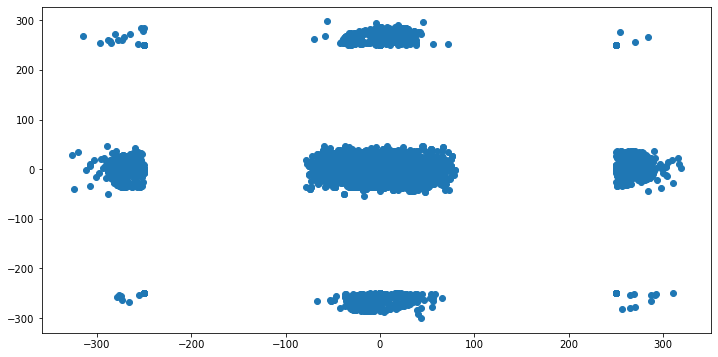

In [110]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['sensor-1'], df['sensor-3'])
plt.show()

Text(0.5, 1.0, 'sensor-4')

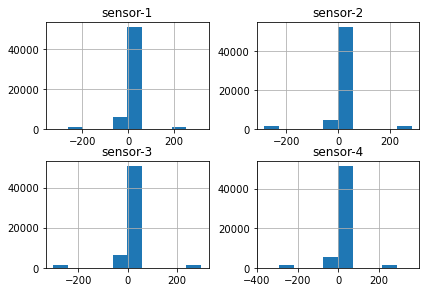

In [111]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
plt.subplot(2,2,1)
df['sensor-1'].hist()
plt.title('sensor-1')
plt.subplot(2,2,2)
df['sensor-2'].hist()
plt.title('sensor-2')
plt.subplot(2,2,3)
df['sensor-3'].hist()
plt.title('sensor-3')
plt.subplot(2,2,4)
df['sensor-4'].hist()
plt.title('sensor-4')

Now lets run a test and filter out all the data that is NOT within one standard deviation of the mean (I used 60 just as an example since it runs so closely to all the columns). Next I am going to find the frequency of these values on any given day and then plot this data using machine_0 exclusively instead of combining machine data as the machines could be unique

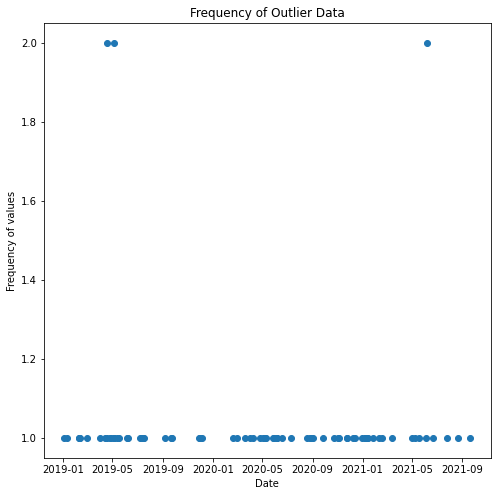

In [126]:
new = df['date'].str.split(" ", n = 1, expand = True)
df['date'] = new[0]

new = df.loc[(df['sensor-1'] >= df['sensor-1'].std()) & (df['Key'] == 'machine_0')]
df1 = new['date'].value_counts().rename_axis('date').reset_index(name = 'counts')
df1['date'] = pd.to_datetime(df1['date'])
df1.sort_values(by='date', ascending=True) # This now sorts in date order


plt.figure(figsize=(8, 8))
plt.title("Frequency of Outlier Data")
plt.xlabel("Date")
plt.ylabel("Frequency of values")
plt.plot_date(df1.date, df1.counts)
plt.show()



We can see that there is no unique pattern with a frequency increase or decrease within any of the machines as the years progress. Lets identify the outliers with interquartile range(IQR). This is a simple test that finds values that do not fall in between 25th and 75th percentile.


In [127]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

sensor-1    0.020314
sensor-2    0.020190
sensor-3    0.020112
sensor-4    0.020242
dtype: float64


After having looked at this range and also referred to the visualizations, I am confident that the data outside this range are outliers.
Next, Lets treat the outliers using an IQR range and what we found above. anything outside of the Q1-Q3 range will be removed. (This is a general rule of thumb and since the tails are such extreme outliers, they are easy to spot and filter) 

In [128]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis = 1)]

Lets take a look at the new shape of this data.

In [129]:
print(df.shape)

(37683, 6)


Now, lets see this data in a scatterplot to see what it looks like without outliers (The given relationship between columns  all yield the same results via scatterplot. I chose to use 1 and 3 but this was just an example)

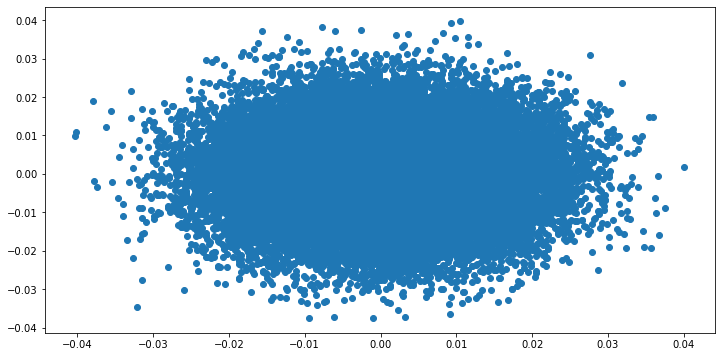

In [130]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df['sensor-1'], df['sensor-3'])
plt.show()

As we can see, the outliers have been removed. Lets check out the new statistical moments.

In [131]:
print(df.describe())

           sensor-1      sensor-2      sensor-3      sensor-4
count  37683.000000  37683.000000  37683.000000  37683.000000
mean       0.000026     -0.000111     -0.000036     -0.000026
std        0.010126      0.010054      0.010014      0.010035
min       -0.040245     -0.038258     -0.037488     -0.039143
25%       -0.006805     -0.006885     -0.006812     -0.006774
50%        0.000016     -0.000134     -0.000019     -0.000069
75%        0.006723      0.006693      0.006757      0.006756
max        0.040030      0.036728      0.039667      0.039365


Lets map this data into an in-memory SQLite database for simplicity

In [132]:
engine = create_engine('sqlite://', echo=False)
df.to_sql('machine', con = engine)
engine.execute("SELECT * FROM machine LIMIT 10").fetchall()

[(397, '2019-05-13', 0.0039460220901702, 0.0091802659852136, 0.0048829984657153, 0.0100350785801525, 'machine_0'),
 (400, '2019-05-14', -0.0066527063651501, -0.0030631511639578, -0.0043790200842087, 0.0022761625827735, 'machine_0'),
 (401, '2019-05-14', -0.0011256091087574, 0.0122489103313204, -0.001379886122787, 0.0067996980588971, 'machine_0'),
 (402, '2019-05-15', -0.0025412189308516, 0.0183867085534296, -0.0116037135717102, -0.0044641404657059, 'machine_0'),
 (404, '2019-05-15', 0.0179779944789983, 0.0019509496922229, -0.0013564043042271, -0.0088443357080387, 'machine_0'),
 (407, '2019-05-16', 0.0075539036494586, -0.010361359296856, 0.0042278533416301, 0.0060094252309562, 'machine_0'),
 (409, '2019-05-17', -0.0197646829402048, -0.0024153329613848, -0.0076552795568156, 0.0067388455698819, 'machine_0'),
 (410, '2019-05-17', -0.0158954686399675, -0.0061611395344072, 2.1699680292157107e-05, -0.008796170651247, 'machine_0'),
 (411, '2019-05-18', 0.0028453697835274, 0.0112944802404586, 0